### This is just simple reproducement of the code available at 

http://wiseodd.github.io/techblog/2016/12/17/conditional-vae/

In [170]:
from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
import tensorflow as tf

In [24]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
X_train, y_train = mnist.train.images, mnist.train.labels
X_test, y_test = mnist.test.images, mnist.test.labels

m = 50
n_x = X_train.shape[1]
n_y = y_train.shape[1]
n_z = 2
n_epoch = 20

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


#### Notation

$x$ - image,

$y$ - label,

$z$ - hidden variable

In [58]:
X = Input(shape=[n_x])
cond = Input(shape=[n_y])
inputs = concatenate([X, cond])

#### Encoder network

$ q(z|x,y) \sim \mathcal{N}(\mu_1(x, \theta), \sigma_1(x, \theta)) $

In [60]:
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model([X, cond], mu)

In [64]:
encoder.predict([X_train[0:10], y_train[0:10]])

array([[ 0.08301225, -0.46163154],
       [ 0.55257177,  0.07319692],
       [-0.36054221, -0.02031484],
       [-0.12453099, -0.4002367 ],
       [ 0.07757197, -0.42440763],
       [ 0.08123612, -0.03703713],
       [ 0.20135036, -0.48151165],
       [-0.67630517, -0.20125806],
       [-0.51006818, -0.14518163],
       [ 0.17778093,  0.07543123]], dtype=float32)

In [172]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=[n_z], mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X,y)
z = Lambda(sample_z)([mu, log_sigma])
z_cond = concatenate([z, cond], axis=1) # <--- NEW!

#### Decoder network

$ p(x|z,y) $

In [111]:
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z_cond)
outputs = decoder_out(h_p)

decoder_input = Input(shape=[n_z+n_y])
decoder_hidden = decoder_hidden(decoder_input)
decoder_out = decoder_out(decoder_hidden)
decoder = Model(decoder_input, decoder_out)

In [112]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs=[X, cond], outputs=outputs)

In [113]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    return recon + kl

In [114]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit([X_train, y_train], [X_train], batch_size=50, nb_epoch=n_epoch, validation_split=0.1)

/Users/sergey/BiternionNet/py_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 49500 samples, validate on 5500 samples
Epoch 1/20
49500/49500 [==============================] - 15s - loss: 163.7087 - val_loss: 141.0603
Epoch 2/20
49500/49500 [==============================] - 13s - loss: 140.3795 - val_loss: 136.6145
Epoch 3/20
49500/49500 [==============================] - 13s - loss: 137.2151 - val_loss: 135.3654
Epoch 4/20
49500/49500 [==============================] - 13s - loss: 135.6825 - val_loss: 133.9347
Epoch 5/20
49500/49500 [==============================] - 13s - loss: 134.5740 - val_loss: 133.9799
Epoch 6/20
49500/49500 [==============================] - 13s - loss: 133.9874 - val_loss: 132.8224
Epoch 7/20
49500/49500 [==============================] - 13s - loss: 133.4105 - val_loss: 132.4038
Epoch 8/20
49500/49500 [==============================] - 13s - loss: 132.9937 - val_loss: 131.9467
Epoch 9/20
49500/49500 [==============================] - 13s - loss: 132.7063 - val_loss: 132.2058
Epoch 10/20
49500/49500 [==========================

#### Now let's generate some digits

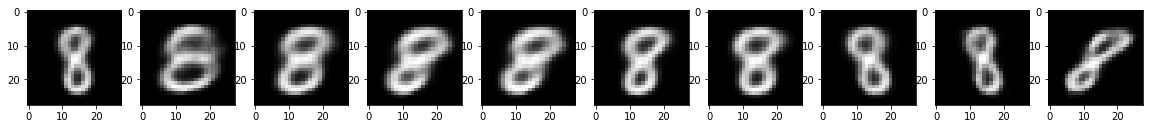

In [168]:
digit_to_generate = 8
n_samples = 10
Y = np.zeros([n_samples, 10])
Y[:, digit_to_generate] = 1
z = np.random.normal(0,1, [n_samples,2])
decoder_input = np.concatenate([z, Y],axis=1)

imgs = decoder.predict(decoder_input)

fig, axs = plt.subplots(1, 10, figsize=(20, 10))
for i in range(0, n_samples):
    axs[i].imshow(imgs[i].reshape(28,28), cmap='gray')